<a href="https://colab.research.google.com/github/KoMurase/-/blob/master/SSD_dot_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
path = '/content/drive/My Drive/phoxter/'

In [0]:
import os.path as osp
import random
import time

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data

import matplotlib.pyplot as plt

In [0]:
import torch.nn.functional as F
from torch.autograd import Function
import torch
import cv2
import numpy as np
import os.path as osp
from itertools import product as product
from math import sqrt as sqrt

In [4]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

使用デバイス： cuda:0


In [0]:
train_dot_df = pd.read_csv(path + 'train_dot.csv')

In [6]:
train_dot_df

,img,box_name,xmin,ymin,xmax,ymax,name
0,dot/190809085119_805_001_B1011-27800-2.png,13,101.0,186.0,167.0,277.0,H
1,dot/190809085119_805_001_B1011-27800-2.png,8,176.0,188.0,236.0,275.0,8
2,dot/190809085119_805_001_B1011-27800-2.png,10,249.0,220.0,309.0,237.0,-
3,dot/190809085119_805_001_B1011-27800-2.png,6,321.0,187.0,387.0,273.0,6
4,dot/190809085119_805_001_B1011-27800-2.png,0,398.0,190.0,464.0,275.0,0
...,...,...,...,...,...,...,...
5707,dot/190906090318_805_001_B1011-27800-2.png,5,196.0,243.0,256.0,326.0,5
5708,dot/190906090318_805_001_B1011-27800-2.png,10,273.0,273.0,330.0,288.0,-
5709,dot/190906090318_805_001_B1011-27800-2.png,5,344.0,246.0,404.0,326.0,5
5710,dot/190906090318_805_001_B1011-27800-2.png,0,419.0,239.0,480.0,323.0,0


In [0]:
f = open(path + '/labels.txt')
lines = f.readlines()
labels = {}
count=0
for line in lines:
  line = line.replace('\n','')
  labels.update({count:line})
  count += 1

In [8]:
labels

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '-',
 11: ':',
 12: 'D',
 13: 'H',
 14: 'I',
 15: 'K',
 16: 'L',
 17: 'M',
 18: 'N',
 19: 'O',
 20: 'R',
 21: 'S',
 22: 'T',
 23: 'U',
 24: 'V',
 25: 'B',
 26: 'o'}

In [0]:
classes = {'0','1','2','3','4','5',
 '6',
 '7',
'8',
'9',
 '-',
 ':',
 'D',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'R',
 'S',
 'T',
 'U',
 'V',
 'B',
 'o'}

In [0]:
classes_index = {}
for i,c in enumerate(classes):
  classes_index.update({c:i})

In [11]:
classes_index

{'-': 3,
 '0': 17,
 '1': 25,
 '2': 26,
 '3': 4,
 '4': 13,
 '5': 1,
 '6': 10,
 '7': 7,
 '8': 11,
 '9': 15,
 ':': 8,
 'B': 19,
 'D': 16,
 'H': 5,
 'I': 2,
 'K': 9,
 'L': 12,
 'M': 23,
 'N': 0,
 'O': 21,
 'R': 14,
 'S': 22,
 'T': 18,
 'U': 20,
 'V': 24,
 'o': 6}

In [0]:
train_dot_df['classes'] = train_dot_df['name'].replace(classes_index)

In [13]:
len(train_dot_df['name'].value_counts() )

25

In [14]:
len( train_dot_df.classes.value_counts() )

25

In [15]:
classes_ = train_dot_df['classes'].unique()
print(classes_)
print(len(classes_) )

[ 5 11  3 10 17  7 15 26  1  8 13 25  4  9 12 16  0 23 14 21 22 18 20 24
  2]
25


In [16]:
train_dot_df.head()

,img,box_name,xmin,ymin,xmax,ymax,name,classes
0,dot/190809085119_805_001_B1011-27800-2.png,13,101.0,186.0,167.0,277.0,H,5
1,dot/190809085119_805_001_B1011-27800-2.png,8,176.0,188.0,236.0,275.0,8,11
2,dot/190809085119_805_001_B1011-27800-2.png,10,249.0,220.0,309.0,237.0,-,3
3,dot/190809085119_805_001_B1011-27800-2.png,6,321.0,187.0,387.0,273.0,6,10
4,dot/190809085119_805_001_B1011-27800-2.png,0,398.0,190.0,464.0,275.0,0,17


In [17]:
train_dot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5712 entries, 0 to 5711
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img       5712 non-null   object 
 1   box_name  5712 non-null   int64  
 2   xmin      5712 non-null   float64
 3   ymin      5712 non-null   float64
 4   xmax      5712 non-null   float64
 5   ymax      5712 non-null   float64
 6   name      5712 non-null   object 
 7   classes   5712 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 357.1+ KB


In [0]:
# ファイルパスのリストを取得
#train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
#    rootpath)

all_img_list = []

for value in train_dot_df['img'].values:
  all_img_list.append(path + value)


In [19]:
print(len(all_img_list))
all_img_list[0:10]

5712


['/content/drive/My Drive/phoxter/dot/190809085119_805_001_B1011-27800-2.png',
 '/content/drive/My Drive/phoxter/dot/190809085119_805_001_B1011-27800-2.png',
 '/content/drive/My Drive/phoxter/dot/190809085119_805_001_B1011-27800-2.png',
 '/content/drive/My Drive/phoxter/dot/190809085119_805_001_B1011-27800-2.png',
 '/content/drive/My Drive/phoxter/dot/190809085119_805_001_B1011-27800-2.png',
 '/content/drive/My Drive/phoxter/dot/190809085119_805_001_B1011-27800-2.png',
 '/content/drive/My Drive/phoxter/dot/190809081818_805_001_B1011-27800-2.png',
 '/content/drive/My Drive/phoxter/dot/190809081818_805_001_B1011-27800-2.png',
 '/content/drive/My Drive/phoxter/dot/190809081818_805_001_B1011-27800-2.png',
 '/content/drive/My Drive/phoxter/dot/190809081818_805_001_B1011-27800-2.png']

In [20]:
TRAIN_SIZE = int (len(all_img_list) * 0.8 )

train_img_list = all_img_list[0:TRAIN_SIZE]
val_img_list = all_img_list[TRAIN_SIZE:]

print(train_img_list[-1])
print(val_img_list[0])
print('train size:',len(train_img_list))
print('validation size:',len(val_img_list))

/content/drive/My Drive/phoxter/dot/190903084934_805_001_B1011-27800-2.png
/content/drive/My Drive/phoxter/dot/190903084934_805_001_B1011-27800-2.png
train size: 4569
validation size: 1143


In [0]:
class Anno_list():
  def __call__(self, idx, df, width, height):
    ret = []
    ymin = df.at[idx,'ymin'] / height
    xmin = df.at[idx,'xmin'] / width
    ymax = df.at[idx,'ymax'] / height
    xmax = df.at[idx,'xmax'] / width
    #label = df.at[idx, 'box_name']
    label = df.at[idx, 'box_name']
    #label_idx = self.classes.index(name)
    bndbox = [xmin, ymin, xmax, ymax, label]
    ret += [bndbox]
    return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]

In [0]:
"""
transform_anno = Anno_list()

# 画像の読み込み OpenCVを使用
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# アノテーションをリストで表示
transform_anno(ind, train_dot_df, width, height)

"""

'\ntransform_anno = Anno_list()\n\n# 画像の読み込み OpenCVを使用\nind = 1\nimage_file_path = val_img_list[ind]\nimg = cv2.imread(image_file_path)  # [高さ][幅][色BGR]\nheight, width, channels = img.shape  # 画像のサイズを取得\n\n# アノテーションをリストで表示\ntransform_anno(ind, train_dot_df, width, height)\n\n'

In [0]:
# フォルダ「utils」にあるdata_augumentation.pyからimport。
# 入力画像の前処理をするクラス
import sys
sys.path.append('/content/drive/My Drive/phoxter/utils')
from data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans
class DataTransform():
    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
               # ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
               # PhotometricDistort(),  # 画像の色調などをランダムに変化
               # Expand(color_mean),  # 画像のキャンバスを広げる
               # RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
               # RandomMirror(),  # 画像を反転させる
               # ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }

    def __call__(self, img, phase, boxes, labels):
       
        return self.data_transform[phase](img, boxes, labels) 

In [0]:
"""

# 動作の確認
# 1. 画像読み込み
idx = 0
image_file_path = train_img_list[idx]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得
print(height, width, channels)

# アノテーションをリストで表示
anno_list = transform_anno(idx, train_dot_df, width, height)

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 5. train画像の表示
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val画像の表示
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

"""

'\n\n# 動作の確認\n# 1. 画像読み込み\nidx = 0\nimage_file_path = train_img_list[idx]\nimg = cv2.imread(image_file_path)  # [高さ][幅][色BGR]\nheight, width, channels = img.shape  # 画像のサイズを取得\nprint(height, width, channels)\n\n# アノテーションをリストで表示\nanno_list = transform_anno(idx, train_dot_df, width, height)\n\n# 3. 元画像の表示\nplt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))\nplt.show()\n\n# 4. 前処理クラスの作成\ncolor_mean = (104, 117, 123)  # (BGR)の色の平均値\ninput_size = 300  # 画像のinputサイズを300×300にする\ntransform = DataTransform(input_size, color_mean)\n\n# 5. train画像の表示\nphase = "train"\nimg_transformed, boxes, labels = transform(\n    img, phase, anno_list[:, :4], anno_list[:, 4])\nplt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))\nplt.show()\n\n\n# 6. val画像の表示\nphase = "val"\nimg_transformed, boxes, labels = transform(\n    img, phase, anno_list[:, :4], anno_list[:, 4])\nplt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))\nplt.show()\n\n'

In [0]:

class Dataset(data.Dataset):
    def __init__(self, img_list, anno_list,phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train もしくは valを指定
        self.transform = transform  # 画像の変形
        self.transform_anno = transform_anno  # アノテーションデータをxmlからリストへ

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のテンソル形式のデータとアノテーションを取得
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
        height, width, channels = img.shape  # 画像のサイズを取得

        """
        # 2. xml形式のアノテーション情報をリストに
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)
        """
        anno_list = self.transform_anno(index, train_dot_df, width, height)

        # 3. 前処理を実施
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 色チャネルの順番がBGRになっているので、RGBに順番変更
        # さらに（高さ、幅、色チャネル）の順を（色チャネル、高さ、幅）に変換
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBoxとラベルをセットにしたnp.arrayを作成、変数名「gt」はground truth（答え）の略称
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

In [24]:
"""

# 動作確認
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

#nameはラベル
#anno_list = transform_anno(idx, train_stamp_df, width, height)
#transform_anno(ind, train_stamp_df, width, height)
train_dataset = Dataset(train_img_list,  phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_list())

val_dataset = Dataset(val_img_list,  phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_list())


# データの取り出し例
val_dataset.__getitem__(1)

"""

'\n\n# 動作確認\ncolor_mean = (104, 117, 123)  # (BGR)の色の平均値\ninput_size = 300  # 画像のinputサイズを300×300にする\n\n#nameはラベル\n#anno_list = transform_anno(idx, train_stamp_df, width, height)\n#transform_anno(ind, train_stamp_df, width, height)\ntrain_dataset = Dataset(train_img_list,  phase="train", transform=DataTransform(\n    input_size, color_mean), transform_anno=Anno_list())\n\nval_dataset = Dataset(val_img_list,  phase="val", transform=DataTransform(\n    input_size, color_mean), transform_anno=Anno_list())\n\n\n# データの取り出し例\nval_dataset.__getitem__(1)\n\n'

In [0]:
def od_collate_fn(batch):
    """
    Datasetから取り出すアノテーションデータのサイズが画像ごとに異なります。 
    今回は画像の大きさは全て同じ。
    画像内の物体数が2個であれば(2, 5)というサイズですが、3個であれば（3, 5）など変化します。
    この変化に対応したDataLoaderを作成するために、
    カスタイマイズした、collate_fnを作成します。
    collate_fnは、PyTorchでリストからmini-batchを作成する関数です。
    ミニバッチ分の画像が並んでいるリスト変数batchに、
    ミニバッチ番号を指定する次元を先頭に1つ追加して、リストの形を変形します。
    """
    
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0] は画像imgです
        targets.append(torch.FloatTensor(sample[1]))  # sample[1] はアノテーションgtです

    # imgsはミニバッチサイズのリストになっています
    # リストの要素はtorch.Size([3, 300, 300])です。
    # このリストをtorch.Size([batch_num, 3, 300, 300])のテンソルに変換します
    imgs = torch.stack(imgs, dim=0)

    # targetsはアノテーションデータの正解であるgtのリストです。
    # リストのサイズはミニバッチサイズです。
    # リストtargetsの要素は [n, 5] となっています。
    # nは画像ごとに異なり、画像内にある物体の数となります。
    # 5は [xmin, ymin, xmax, ymax, class_index] です

    return imgs, targets

In [26]:
"""

# データローダーの作成

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images, targets = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数


"""

'\n\n# データローダーの作成\n\nbatch_size = 4\n\ntrain_dataloader = data.DataLoader(\n    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)\n\nval_dataloader = data.DataLoader(\n    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)\n\n# 辞書型変数にまとめる\ndataloaders_dict = {"train": train_dataloader, "val": val_dataloader}\n\n# 動作の確認\nbatch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換\nimages, targets = next(batch_iterator)  # 1番目の要素を取り出す\nprint(images.size())  # torch.Size([4, 3, 300, 300])\nprint(len(targets))\nprint(targets[1].size())  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数\n\n\n'

In [27]:
"""
print(train_dataset.__len__())
print(val_dataset.__len__())
"""

'\nprint(train_dataset.__len__())\nprint(val_dataset.__len__())\n'

In [0]:
# 34層にわたる、vggモジュールを作成
def make_vgg():
    layers = []
    in_channels = 3  # 色チャネル数

    # vggモジュールで使用する畳み込み層やマックスプーリングのチャネル数
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceilは出力サイズを、計算結果（float）に対して、切り上げで整数にするモード
            # デフォルトでは出力サイズを計算結果（float）に対して、切り下げで整数にするfloorモード
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)

In [29]:
# 動作確認
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

In [0]:
# 8層にわたる、extrasモジュールを作成
def make_extras():
    layers = []
    in_channels = 1024  # vggモジュールから出力された、extraに入力される画像チャネル数

    # extraモジュールの畳み込み層のチャネル数を設定するコンフィギュレーション
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]

    return nn.ModuleList(layers)

In [0]:
# デフォルトボックスのオフセットを出力するloc_layers、
# デフォルトボックスに対する各クラスの確率を出力するconf_layersを作成

def make_loc_conf(num_classes=len(classes), bbox_aspect_num=[4, 6, 6, 6, 4, 4]):

    loc_layers = []
    conf_layers = []

    # VGGの22層目、conv4_3（source1）に対する畳み込み層
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                              * num_classes, kernel_size=3, padding=1)]

    # VGGの最終層（source2）に対する畳み込み層
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source3）に対する畳み込み層
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source4）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source5）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source6）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)


In [32]:
# 動作確認
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 162, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 162, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 162, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [0]:
# convC4_3からの出力をscale=20のL2Normで正規化する層
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  # 親クラスのコンストラクタ実行
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale  # 係数weightの初期値として設定する値
        self.reset_parameters()  # パラメータの初期化
        self.eps = 1e-10

    def reset_parameters(self):
        '''結合パラメータを大きさscaleの値にする初期化を実行'''
        init.constant_(self.weight, self.scale)  # weightの値がすべてscale（=20）になる

    def forward(self, x):
        '''38×38の特徴量に対して、512チャネルにわたって2乗和のルートを求めた
        38×38個の値を使用し、各特徴量を正規化してから係数をかけ算する層'''

        # 各チャネルにおける38×38個の特徴量のチャネル方向の2乗和を計算し、
        # さらにルートを求め、割り算して正規化する
        # normのテンソルサイズはtorch.Size([batch_num, 1, 38, 38])になります
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # 係数をかける。係数はチャネルごとに1つで、512個の係数を持つ
        # self.weightのテンソルサイズはtorch.Size([512])なので
        # torch.Size([batch_num, 512, 38, 38])まで変形します
        weights = self.weight.unsqueeze(
            0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

In [0]:
# デフォルトボックスを出力するクラス
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # 初期設定
        self.image_size = cfg['input_size']  # 画像サイズの300
        # [38, 19, …] 各sourceの特徴量マップのサイズ
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg["feature_maps"])  # sourceの個数=6
        self.steps = cfg['steps']  # [8, 16, …] DBoxのピクセルサイズ
        self.min_sizes = cfg['min_sizes']  # [30, 60, …] 小さい正方形のDBoxのピクセルサイズ
        self.max_sizes = cfg['max_sizes']  # [60, 111, …] 大きい正方形のDBoxのピクセルサイズ
        self.aspect_ratios = cfg['aspect_ratios']  # 長方形のDBoxのアスペクト比

    def make_dbox_list(self):
        '''DBoxを作成する'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):  # fまでの数で2ペアの組み合わせを作る　f_P_2 個
                # 特徴量の画像サイズ
                # 300 / 'steps': [8, 16, 32, 64, 100, 300],
                f_k = self.image_size / self.steps[k]

                # DBoxの中心座標 x,y　ただし、0～1で規格化している
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                # アスペクト比1の小さいDBox [cx,cy, width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # アスペクト比1の大きいDBox [cx,cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # その他のアスペクト比のdefBox [cx,cy, width, height]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]

        # DBoxをテンソルに変換 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBoxの大きさが1を超えている場合は1にする
        output.clamp_(max=1, min=0)

        return output


In [35]:
# 動作の確認

# SSD300の設定
ssd_cfg = {
    'num_classes': len(classes) + 1,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# DBoxの出力を確認する
pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


In [36]:

# SSDクラスを作成する
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inferenceを指定
        self.num_classes = cfg["num_classes"]  # クラス数=21

        # SSDのネットワークを作る
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox作成
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 推論時はクラス「Detect」を用意します
        if phase == 'inference':
            self.detect = Detect()


# 動作確認
ssd_test = SSD(phase="train", cfg=ssd_cfg)
print(ssd_test)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [0]:
# オフセット情報を使い、DBoxをBBoxに変換する関数
def decode(loc, dbox_list):
    """
    オフセット情報を使い、DBoxをBBoxに変換する。
    Parameters
    ----------
    loc:  [8732,4]
        SSDモデルで推論するオフセット情報。
    dbox_list: [8732,4]
        DBoxの情報
    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBoxの情報
    """

    # DBoxは[cx, cy, width, height]で格納されている
    # locも[Δcx, Δcy, Δwidth, Δheight]で格納されている

    # オフセット情報からBBoxを求める
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxesのサイズはtorch.Size([8732, 4])となります

    # BBoxの座標情報を[cx, cy, width, height]から[xmin, ymin, xmax, ymax] に
    boxes[:, :2] -= boxes[:, 2:] / 2  # 座標(xmin,ymin)へ変換
    boxes[:, 2:] += boxes[:, :2]  # 座標(xmax,ymax)へ変換

    return boxes

In [0]:
# Non-Maximum Suppressionを行う関数


def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppressionを行う関数。
    boxesのうち被り過ぎ（overlap以上）のBBoxを削除する。
    Parameters
    ----------
    boxes : [確信度閾値（0.01）を超えたBBox数,4]
        BBox情報。
    scores :[確信度閾値（0.01）を超えたBBox数]
        confの情報
    Returns
    -------
    keep : リスト
        confの降順にnmsを通過したindexが格納
    count：int
        nmsを通過したBBoxの数
    """

    # returnのひな形を作成
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep：torch.Size([確信度閾値を超えたBBox数])、要素は全部0

    # 各BBoxの面積areaを計算
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxesをコピーする。後で、BBoxの被り度合いIOUの計算に使用する際のひな形として用意
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # socreを昇順に並び変える
    v, idx = scores.sort(0)

    # 上位top_k個（200個）のBBoxのindexを取り出す（200個存在しない場合もある）
    idx = idx[-top_k:]

    # idxの要素数が0でない限りループする
    while idx.numel() > 0:
        i = idx[-1]  # 現在のconf最大のindexをiに

        # keepの現在の最後にconf最大のindexを格納する
        # このindexのBBoxと被りが大きいBBoxをこれから消去する
        keep[count] = i
        count += 1

        # 最後のBBoxになった場合は、ループを抜ける
        if idx.size(0) == 1:
            break

        # 現在のconf最大のindexをkeepに格納したので、idxをひとつ減らす
        idx = idx[:-1]

        # -------------------
        # これからkeepに格納したBBoxと被りの大きいBBoxを抽出して除去する
        # -------------------
        # ひとつ減らしたidxまでのBBoxを、outに指定した変数として作成する
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # すべてのBBoxに対して、現在のBBox=indexがiと被っている値までに設定(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # wとhのテンソルサイズをindexを1つ減らしたものにする
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clampした状態でのBBoxの幅と高さを求める
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 幅や高さが負になっているものは0にする
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clampされた状態での面積を求める
        inter = tmp_w*tmp_h

        # IoU = intersect部分 / (area(a) + area(b) - intersect部分)の計算
        rem_areas = torch.index_select(area, 0, idx)  # 各BBoxの元の面積
        union = (rem_areas - inter) + area[i]  # 2つのエリアのANDの面積
        IoU = inter/union

        # IoUがoverlapより小さいidxのみを残す
        idx = idx[IoU.le(overlap)]  # leはLess than or Equal toの処理をする演算です
        # IoUがoverlapより大きいidxは、最初に選んでkeepに格納したidxと同じ物体に対してBBoxを囲んでいるため消去

    # whileのループが抜けたら終了

    return keep, count

In [0]:
# SSDクラスを作成する
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inferenceを指定
        self.num_classes = cfg["num_classes"]  # クラス数=21

        # SSDのネットワークを作る
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox作成
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 推論時はクラス「Detect」を用意します
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # locとconfへの入力source1～6を格納
        loc = list()  # locの出力を格納
        conf = list()  # confの出力を格納

        # vggのconv4_3まで計算する
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3の出力をL2Normに入力し、source1を作成、sourcesに追加
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vggを最後まで計算し、source2を作成、sourcesに追加
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extrasのconvとReLUを計算
        # source3～6を、sourcesに追加
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLUをしたらsourceに入れる
                sources.append(x)

        # source1～6に、それぞれ対応する畳み込みを1回ずつ適用する
        # zipでforループの複数のリストの要素を取得
        # source1～6まであるので、6回ループが回る
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permuteは要素の順番を入れ替え
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)とc(x)で畳み込みを実行
            # l(x)とc(x)の出力サイズは[batch_num, 4*アスペクト比の種類数, featuremapの高さ, featuremap幅]
            # sourceによって、アスペクト比の種類数が異なり、面倒なので順番入れ替えて整える
            # permuteで要素の順番を入れ替え、
            # [minibatch数, featuremap数, featuremap数,4*アスペクト比の種類数]へ
            # （注釈）
            # torch.contiguous()はメモリ上で要素を連続的に配置し直す命令です。
            # あとでview関数を使用します。
            # このviewを行うためには、対象の変数がメモリ上で連続配置されている必要があります。

        # さらにlocとconfの形を変形
        # locのサイズは、torch.Size([batch_num, 34928])
        # confのサイズはtorch.Size([batch_num, 183372])になる
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # さらにlocとconfの形を整える
        # locのサイズは、torch.Size([batch_num, 8732, 4])
        # confのサイズは、torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 最後に出力する
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  # 推論時
            # クラス「Detect」のforwardを実行
            # 返り値のサイズは torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 学習時
            return output

In [0]:
import sys
sys.path.append('/content/drive/My Drive/phoxter/utils/')
from match import match
#import importlib
#importlib.reload(match)

class MultiBoxLoss(nn.Module):
    """SSDの損失関数のクラスです。"""

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 関数matchのjaccard係数の閾値
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Miningの負と正の比率
        self.device = device  # CPUとGPUのいずれで計算するのか

    def forward(self, predictions, targets):
        """
        損失関数の計算。
        Parameters
        ----------
        predictions : SSD netの訓練時の出力(tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])。
        targets : [num_batch, num_objs, 5]
            5は正解のアノテーション情報[xmin, ymin, xmax, ymax, label_ind]を示す
        Returns
        -------
        loss_l : テンソル
            locの損失の値
        loss_c : テンソル
            confの損失の値
        """

        # SSDモデルの出力がタプルになっているので、個々にばらす
        loc_data, conf_data, dbox_list = predictions

        # 要素数を把握
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21

        # 損失の計算に使用するものを格納する変数を作成
        # conf_t_label：各DBoxに一番近い正解のBBoxのラベルを格納させる
        # loc_t:各DBoxに一番近い正解のBBoxの位置情報を格納させる
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_tとconf_t_labelに、
        # DBoxと正解アノテーションtargetsをmatchさせた結果を上書きする
        for idx in range(num_batch):  # ミニバッチでループ

            # 現在のミニバッチの正解アノテーションのBBoxとラベルを取得
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # ラベル [物体1のラベル, 物体2のラベル, …]
            labels = targets[idx][:, -1].to(self.device)

            # デフォルトボックスを新たな変数で用意
            dbox = dbox_list.to(self.device)

            # 関数matchを実行し、loc_tとconf_t_labelの内容を更新する
            # （詳細）
            # loc_t:各DBoxに一番近い正解のBBoxの位置情報が上書きされる
            # conf_t_label：各DBoxに一番近いBBoxのラベルが上書きされる
            # ただし、一番近いBBoxとのjaccard overlapが0.5より小さい場合は
            # 正解BBoxのラベルconf_t_labelは背景クラスの0とする
            variance = [0.1, 0.2]
            # このvarianceはDBoxからBBoxに補正計算する際に使用する式の係数です
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # 位置の損失：loss_lを計算
        # Smooth L1関数で損失を計算する。ただし、物体を発見したDBoxのオフセットのみを計算する
        # ----------
        # 物体を検出したBBoxを取り出すマスクを作成
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_maskをloc_dataのサイズに変形
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBoxのloc_dataと、教師データloc_tを取得
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 物体を発見したPositive DBoxのオフセット情報loc_tの損失（誤差）を計算
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # クラス予測の損失：loss_cを計算
        # 交差エントロピー誤差関数で損失を計算する。ただし、背景クラスが正解であるDBoxが圧倒的に多いので、
        # Hard Negative Miningを実施し、物体発見DBoxと背景クラスDBoxの比が1:3になるようにする。
        # そこで背景クラスDBoxと予想したもののうち、損失が小さいものは、クラス予測の損失から除く
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # クラス予測の損失を関数を計算(reduction='none'にして、和をとらず、次元をつぶさない)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # 物体発見したPositive DBoxの損失を0にする
        # （注意）物体はlabelが1以上になっている。ラベル0は背景。
        num_pos = pos_mask.long().sum(1, keepdim=True)  # ミニバッチごとの物体クラス予測の数
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 物体を発見したDBoxは損失0とする

        # Hard Negative Miningを実施する
        # 各DBoxの損失の大きさloss_cの順位であるidx_rankを求める
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        # （注釈）
        # 実装コードがかなり特殊で直感的ではないです。
        # 上記2行は、要は各DBoxに対して、損失の大きさが何番目なのかの情報を
        # 変数idx_rankとして高速に取得したいというコードです。
        #
        # DBOXの損失値の大きい方から降順に並べ、DBoxの降順のindexをloss_idxに格納。
        # 損失の大きさloss_cの順位であるidx_rankを求める。
        # ここで、
        # 降順になった配列indexであるloss_idxを、0から8732まで昇順に並べ直すためには、
        # 何番目のloss_idxのインデックスをとってきたら良いのかを示すのが、idx_rankである。
        # 例えば、
        # idx_rankの要素0番目 = idx_rank[0]を求めるには、loss_idxの値が0の要素、
        # つまりloss_idx[?}=0 の、?は何番かを求めることになる。ここで、? = idx_rank[0]である。
        # いま、loss_idx[?]=0の0は、元のloss_cの要素の0番目という意味である。
        # つまり?は、元のloss_cの要素0番目は、降順に並び替えられたloss_idxの何番目ですか
        # を求めていることになり、 結果、
        # ? = idx_rank[0] はloss_cの要素0番目が、降順の何番目かを示すことになる。

        # 背景のDBoxの数num_negを決める。HardNegative Miningにより、
        # 物体発見のDBoxの数num_posの3倍（self.negpos_ratio倍）とする。
        # ただし、万が一、DBoxの数を超える場合は、DBoxの数を上限とする
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rankは各DBoxの損失の大きさが上から何番目なのかが入っている
        # 背景のDBoxの数num_negよりも、順位が低い（すなわち損失が大きい）DBoxを取るマスク作成
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # （終了）これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # マスクの形を整形し、conf_dataに合わせる
        # pos_idx_maskはPositive DBoxのconfを取り出すマスクです
        # neg_idx_maskはHard Negative Miningで抽出したNegative DBoxのconfを取り出すマスクです
        # pos_mask：torch.Size([num_batch, 8732])→pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_dataからposとnegだけを取り出してconf_hnmにする。形はtorch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # （注釈）gtは greater than (>)の略称。これでmaskが1のindexを取り出す。
        # pos_idx_mask+neg_idx_maskは足し算だが、indexへのmaskをまとめているだけである。
        # つまり、posであろうがnegであろうが、マスクが1のものを足し算で一つのリストにし、それをgtで取得

        # 同様に教師データであるconf_t_labelからposとnegだけを取り出してconf_t_label_hnmに
        # 形はtorch.Size([pos+neg])になる
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidenceの損失関数を計算（要素の合計=sumを求める）
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 物体を発見したBBoxの数N（全ミニバッチの合計）で損失を割り算
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c

In [41]:
# SSD300の設定
ssd_cfg = {
    'num_classes': len(classes) + 1,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="train", cfg=ssd_cfg)

# SSDの初期の重みを設定
# ssdのvgg部分に重みをロードする
WEIGHT_DIR = '/content/drive/My Drive/phoxter/weights'
vgg_weights = torch.load(WEIGHT_DIR + '/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

# ssdのその他のネットワークの重みはHeの初期値で初期化


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)


# Heの初期値を適用
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

print('ネットワーク設定完了：学習済みの重みをロードしました')


使用デバイス： cuda:0
ネットワーク設定完了：学習済みの重みをロードしました


In [0]:

# 損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 最適化手法の設定
optimizer = optim.SGD(net.parameters(), lr=0.0001,
                      momentum=0.9, weight_decay=5e-4)

In [0]:
# モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []
    #es = EarlyStopping(patience=10, verbose=1)



    # epochのループ
    for epoch in range(num_epochs+1):
          
        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('（train）')
            else:
                #if((epoch+1) % 10 == 0):
                if((epoch+1) % 1 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は毎回
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, targets in dataloaders_dict[phase]:

                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # リストの各要素のテンソルをGPUへ

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs = net(images)

                    # 損失の計算
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv(path + "log_output.csv")

        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        # ネットワークを保存する
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), WEIGHT_DIR+'/ssd300_' +
                       str(epoch+1) + '.pth')

In [44]:
# Datasetを作成
TRAIN_SIZE = int (len(all_img_list) * 0.8 )

train_img_list = all_img_list[0:TRAIN_SIZE]
val_img_list = all_img_list[TRAIN_SIZE:]

print(train_img_list[-1])
print(val_img_list[0])
print('train size:',len(train_img_list))
print('validation size:',len(val_img_list))


color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = Dataset(train_img_list, train_img_list,phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_list())

val_dataset = Dataset(val_img_list, val_img_list,phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_list())


# DataLoaderを作成する
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


/content/drive/My Drive/phoxter/dot/190903084934_805_001_B1011-27800-2.png
/content/drive/My Drive/phoxter/dot/190903084934_805_001_B1011-27800-2.png
train size: 4569
validation size: 1143


In [45]:
# 学習・検証を実行する
num_epochs= 50
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 1/50
-------------
（train）
イテレーション 10 || Loss: 17.8441 || 10iter: 247.3241 sec.
イテレーション 20 || Loss: 14.5816 || 10iter: 180.3321 sec.
イテレーション 30 || Loss: 13.2425 || 10iter: 142.2520 sec.
イテレーション 40 || Loss: 10.8103 || 10iter: 86.7099 sec.
イテレーション 50 || Loss: 6.6989 || 10iter: 61.4047 sec.
イテレーション 60 || Loss: 6.5160 || 10iter: 43.3605 sec.
イテレーション 70 || Loss: 5.9326 || 10iter: 34.4540 sec.
イテレーション 80 || Loss: 5.8623 || 10iter: 28.9959 sec.
イテレーション 90 || Loss: 5.5620 || 10iter: 36.7506 sec.
イテレーション 100 || Loss: 5.5225 || 10iter: 23.6647 sec.
イテレーション 110 || Loss: 5.5098 || 10iter: 23.5483 sec.
イテレーション 120 || Loss: 4.9242 || 10iter: 23.5035 sec.
イテレーション 130 || Loss: 4.6940 || 10iter: 23.6313 sec.
イテレーション 140 || Loss: 5.1981 || 10iter: 23.5819 sec.
-------------
（val）
-------------
epoch 1 || Epoch_TRAIN_Loss:1249.1587 ||Epoch_VAL_Loss:294.7111
timer:  1212.6480 sec.
-------------
Epoch 2/50
-------------
（train）
イテレーション 150 || Loss: 4.8419 || 10iter: 16.08

In [0]:
log_output = pd.read_csv(path + 'log_output.csv')

In [47]:
log_output

,Unnamed: 0,epoch,train_loss,val_loss
0,0,1,1249.158659,294.711149
1,1,2,605.281198,311.634125
2,2,3,515.715875,326.073635
3,3,4,469.613664,338.999422
4,4,5,444.073776,343.448923
5,5,6,427.789749,350.530606
6,6,7,415.578062,354.588650
7,7,8,407.414358,356.979826
8,8,9,400.440418,361.370153
9,9,10,396.125629,361.123581


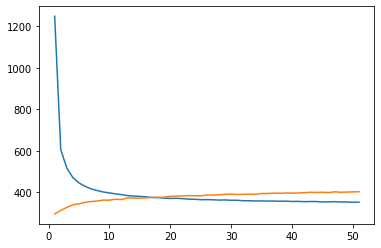

In [51]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
#ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(log_output['epoch'],log_output['train_loss'])
ax1.plot(log_output['epoch'],log_output['val_loss'])
